## Domain adaptation

In [167]:
import fasttext
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import re
from nltk.tokenize import TweetTokenizer
from IPython.display import clear_output

In [48]:
DATADIR = "../data/"
DISTANCE = "distance"
FILEFASTTEXT = "fasttext-"+TOPIC+".csv"
IDSTR = "id_str"
IRRELEVANT = "IRRELEVANT"
NEUTRAL = "NEUTRAL"
ANDERS = "ANDERS"
EENS = "EENS"
ONEENS = "ONEENS"
SUPPORTS = "SUPPORTS"
REJECTS = "REJECTS"
LABEL = "label"
TEXT = "text"
USER = "user"
LABELPREFIX = "__label__"
LARGEINT = 9999999999

In [124]:
def cleanup(text):
    text = re.sub(r"\\n"," ",text)
    text = re.sub(r"https://\S+","",text)
    text = re.sub(r"\s+"," ",text)
    text = text.strip()
    return(text)


def tokenize(text):
    return(" ".join(TweetTokenizer().tokenize(text)))


def preprocess(text):
    return(tokenize(cleanup(text)).lower())


def select_annotations(tweets, annotations, target_annotator):
    fasttext_data = {}
    for i in range(0,len(annotations)):
        annotator = annotations.iloc[i][0]
        tweet_id = annotations.iloc[i][2]
        if annotator == target_annotator and tweet_id in list(tweets.index):
            tweet_user = tweets.loc[tweet_id][1]
            tweet_label = annotations.iloc[i][4]
            if tweet_label == NEUTRAL: tweet_label = IRRELEVANT
            if tweet_label == ANDERS: tweet_label = IRRELEVANT
            if tweet_label == EENS: tweet_label = SUPPORTS
            if tweet_label == ONEENS: tweet_label = REJECTS
            fasttext_data[tweet_id] = { LABEL:LABELPREFIX+tweet_label,
                                        USER:tweet_user,
                                        TEXT:preprocess(tweets.loc[tweet_id][TEXT]) }
    return(fasttext_data)


def store_fasttext_data(fasttext_data):
    outfile = open(FILEFASTTEXT, "w")
    seen_texts = {}
    fasttext_data_list = []
    tweet_ids = []
    for tweet_id in fasttext_data:
        text = cleanup(fasttext_data[tweet_id][TEXT])
        if not text in seen_texts:
            print(fasttext_data[tweet_id][LABEL], text, file=outfile)
            fasttext_data_list.append(" ".join([fasttext_data[tweet_id][LABEL], text]))
            tweet_ids.append(tweet_id)
            seen_texts[text] = True
    outfile.close()
    return(fasttext_data_list, tweet_ids)

In [125]:
def make_fasttext_data(topic):
    if topic == DISTANCE:
        tweet_file = DATADIR + topic + "-tweets.csv"
    else:
        tweet_file = DATADIR + topic + "-tweets+nunl.csv"
    tweets = pd.read_csv(tweet_file, index_col=IDSTR)   
    annotations = pd.read_csv(tweet_file + ".human-labels.txt", header=None, sep=" ")        
    main_annotator = annotations.iloc[0][0]
    fasttext_data = select_annotations(tweets, annotations, main_annotator)
    fasttext_data_list, tweet_ids = store_fasttext_data(fasttext_data)
    return(fasttext_data_list, tweet_ids)

In [133]:
def makeConfusionMatrix(fasttextData,predictionLabels):
    goldLabels = pd.Series([fasttextData[i].split()[0] for i in range(0,len(fasttextData))])
    predictedLabels = pd.Series([x[0] for row in predictionLabels for x in row[0]])
    return(pd.crosstab(goldLabels,predictedLabels))

def evaluate(predictionCounts,predictionLabels,fasttextData,printResults=True,printMatrix=False):
    caseTotal = 0
    pTotal = 0
    rTotal = 0
    for i in range(0,len(predictionCounts)):
        caseTotal += predictionCounts[i][0]
        pTotal += predictionCounts[i][0]*predictionCounts[i][1]
        rTotal += predictionCounts[i][0]*predictionCounts[i][2]
    precision = round(pTotal/caseTotal,3)
    recall = round(rTotal/caseTotal,3)
    cf = makeConfusionMatrix(fasttextData,predictionLabels)
    if printMatrix:
        print(cf)
    for label in ['__label__REJECTS','__label__SUPPORTS','__label__IRRELEVANT']:
        if not label in cf: cf[label] = [0 for i in range(0,len(cf))]
    numberOfPredictedSupportLabels = sum([cf.iloc[i]['__label__SUPPORTS'] for i in range(0,len(cf))])
    numberOfGoldSupportLabels = sum(cf.loc['__label__SUPPORTS'])
    numberOfPredictedRejectLabels = sum([cf.iloc[i]['__label__REJECTS'] for i in range(0,len(cf))])
    numberOfGoldRejectLabels = sum(cf.loc['__label__REJECTS'])
    if numberOfPredictedSupportLabels > 0 and numberOfGoldRejectLabels > 0 and numberOfGoldSupportLabels > 0:
        fraction = (numberOfPredictedRejectLabels/numberOfPredictedSupportLabels)/(numberOfGoldRejectLabels/numberOfGoldSupportLabels)
    else:
        fraction = LARGEINT
    if printResults: 
        print("cases: {0}; precision: {1:0.3f}; recall: {2:0.3f}; fraction: {3:0.3f}".format(caseTotal,precision,recall,fraction))
    return((precision,fraction))

def runFasttext(fasttextData1,fasttextData2,dim=DIM,epoch=EPOCH,lr=LR,n=N,squealFlag=True,maxTrain=None,pretrainedVectors=None):
    predictionCountsTest = []
    predictionLabelsTest = []
    predictionCountsValidation = []
    predictionLabelsValidation = []
    for fold in range(0,n):
        if squealFlag:
            clear_output(wait=True)
            print("starting fold",fold)
        testStart1 = round(fold*len(fasttextData1)/n)
        testEnd1 = round((fold+1)*len(fasttextData1)/n)
        testStart2 = round(fold*len(fasttextData2)/n)
        testEnd2 = round((fold+1)*len(fasttextData2)/n)
        if fold < n-1: nextFold = fold+1
        else: nextFold = 0
        validationStart1 = round(nextFold*len(fasttextData1)/n)
        validationEnd1 = round((nextFold+1)*len(fasttextData1)/n)
        validationStart2 = round(nextFold*len(fasttextData2)/n)
        validationEnd2 = round((nextFold+1)*len(fasttextData2)/n)
        trainFile = open(TRAIN,"w")
        testFile = open(TEST,"w")
        validationFile = open(VALIDATION,"w")
        trainData = []
        validationData = []
        testData = []
        for i in range(0,len(fasttextData1)):
            data = fasttextData1[i]
            if i >= testStart1 and i < testEnd1: 
                pass
            elif i >= validationStart1 and i < validationEnd1: 
                pass
            else: 
                print(data,file=trainFile)
                trainData.append(data)
        for i in range(0,len(fasttextData2)):
            data = fasttextData2[i]
            if i >= testStart2 and i < testEnd2: 
                print(data,file=testFile)
                testData.append(data)
            elif i >= validationStart2 and i < validationEnd2: 
                print(data,file=validationFile)
                validationData.append(data)
        testFile.close()
        trainFile.close()
        validationFile.close()
        if not maxTrain == None and maxTrain < len(trainData):
            trainData = ranSelect(trainData,maxTrain)
            trainFile = open(TRAIN,"w")
            for i in range(0,len(trainData)):
                print(trainData[i],file=trainFile)
            trainFile.close()
        if pretrainedVectors == None:
            model = fasttext.train_supervised(TRAIN, dim=dim, epoch=epoch, lr=lr)
        else:
            model = fasttext.train_supervised(TRAIN, dim=dim, epoch=epoch, lr=lr, pretrainedVectors=pretrainedVectors)
        predictionCountsValidation.append([*model.test(VALIDATION)])
        predictionLabelsValidation.append(model.predict(validationData))
        predictionCountsTest.append([*model.test(TEST)])
        predictionLabelsTest.append(model.predict(testData))
        print(fold, end=" ")
        evaluate([[*model.test(TEST)]], [model.predict(testData)], fasttextData2[testStart2:testEnd2])
        os.unlink(TRAIN)
        os.unlink(TEST)
        os.unlink(VALIDATION)
    print("", end=" ")
    evaluate(predictionCountsTest, predictionLabelsTest, fasttextData2, printMatrix=True)
    if squealFlag:
        clear_output(wait=True)
        print("finished")
    return(predictionCountsValidation,predictionLabelsValidation,predictionCountsTest,predictionLabelsTest)

In [115]:
DIM = 100
EPOCH = 100
LR = 0.05
N = 10
TRAIN = "TRAIN"+str(int(random.random()*LARGEINT))
TEST = "TEST"+str(int(random.random()*LARGEINT))
VALIDATION = "VALIDATION"+str(int(random.random()*LARGEINT))

In [126]:
fasttext_data_list_distance, tweet_ids_distance = make_fasttext_data("distance")
fasttext_data_list_facemask, tweet_ids_facemask = make_fasttext_data("mondkapje")

## Evaluation within domains

In [85]:
predictionCountsValidation,predictionLabelsValidation,predictionCountsTest,predictionLabelsTest = \
    runFasttext(fasttext_data_list_facemask, fasttext_data_list_facemask, squealFlag=False, dim=300, pretrainedVectors="model-2020.vec")

0 cases: 132; precision: 0.591; recall: 0.591; fraction: 1.054
1 cases: 133; precision: 0.654; recall: 0.654; fraction: 3.387
2 cases: 132; precision: 0.614; recall: 0.614; fraction: 6.902
3 cases: 132; precision: 0.538; recall: 0.538; fraction: 0.839
4 cases: 132; precision: 0.576; recall: 0.576; fraction: 1.482
5 cases: 132; precision: 0.568; recall: 0.568; fraction: 1.290
6 cases: 133; precision: 0.579; recall: 0.579; fraction: 1.869
7 cases: 132; precision: 0.470; recall: 0.470; fraction: 1.446
8 cases: 132; precision: 0.417; recall: 0.417; fraction: 2.696
9 cases: 132; precision: 0.689; recall: 0.689; fraction: 2.492
 cases: 1322; precision: 0.570; recall: 0.570; fraction: 1.157


In [233]:
predictionCountsValidation,predictionLabelsValidation,predictionCountsTest,predictionLabelsTest = \
    runFasttext(fasttext_data_list_facemask, fasttext_data_list_facemask, squealFlag=False, dim=300)

0 cases: 132; precision: 0.636; recall: 0.636; fraction: 3.975
1 cases: 132; precision: 0.583; recall: 0.583; fraction: 1.225
2 cases: 133; precision: 0.594; recall: 0.594; fraction: 6.048
3 cases: 132; precision: 0.629; recall: 0.629; fraction: 6.588
4 cases: 132; precision: 0.545; recall: 0.545; fraction: 1.324
5 cases: 132; precision: 0.530; recall: 0.530; fraction: 1.676
6 cases: 132; precision: 0.508; recall: 0.508; fraction: 1.672
7 cases: 133; precision: 0.549; recall: 0.549; fraction: 2.068
8 cases: 132; precision: 0.492; recall: 0.492; fraction: 2.274
9 cases: 132; precision: 0.455; recall: 0.455; fraction: 2.621
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  300               210                 48
__label__REJECTS                     146               374                 29
__label__SUPPORTS                     70                8

In [234]:
predictionCountsValidation,predictionLabelsValidation,predictionCountsTest,predictionLabelsTest = \
    runFasttext(fasttext_data_list_distance, fasttext_data_list_distance, squealFlag=False)

0 cases: 573; precision: 0.606; recall: 0.606; fraction: 1.160
1 cases: 573; precision: 0.750; recall: 0.750; fraction: 1.171
2 cases: 573; precision: 0.546; recall: 0.546; fraction: 0.712
3 cases: 573; precision: 0.625; recall: 0.625; fraction: 1.082
4 cases: 574; precision: 0.578; recall: 0.578; fraction: 0.953
5 cases: 573; precision: 0.614; recall: 0.614; fraction: 0.664
6 cases: 573; precision: 0.627; recall: 0.627; fraction: 0.587
7 cases: 573; precision: 0.667; recall: 0.667; fraction: 0.745
8 cases: 573; precision: 0.642; recall: 0.642; fraction: 0.722
9 cases: 573; precision: 0.627; recall: 0.627; fraction: 0.928
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  530               203                634
__label__REJECTS                     223               566                347
__label__SUPPORTS                    475               24

## Predicting social distancing with facemask data

In [108]:
def count_labels(fasttext_data_list):
    counts = {}
    for i in range(0, len(fasttext_data_list)):
        token_list = fasttext_data_list[i].split()
        if token_list[0] in counts:
            counts[token_list[0]] += 1
        else:
            counts[token_list[0]] = 1
    return(counts)


def swap_labels(fasttext_data_list_in):
    fasttext_data_list_out = []
    for i in range(0, len(fasttext_data_list_in)):
        token_list = fasttext_data_list_in[i].split()
        if token_list[0] == "__label__REJECTS":
            token_list[0] = "__label__SUPPORTS"
        elif token_list[0] == "__label__SUPPORTS":
            token_list[0] = "__label__REJECTS"
        fasttext_data_list_out.append(" ".join(token_list))
    return(fasttext_data_list_out)

In [210]:
predictionCountsValidation,predictionLabelsValidation,predictionCountsTest,predictionLabelsTest = \
    runFasttext(fasttext_data_list_facemask, fasttext_data_list_distance, squealFlag=False, dim=300)

0 cases: 573; precision: 0.290; recall: 0.290; fraction: 14.795
1 cases: 573; precision: 0.349; recall: 0.349; fraction: 9.666
2 cases: 573; precision: 0.335; recall: 0.335; fraction: 4.410
3 cases: 573; precision: 0.346; recall: 0.346; fraction: 5.843
4 cases: 574; precision: 0.314; recall: 0.314; fraction: 8.453
5 cases: 573; precision: 0.318; recall: 0.318; fraction: 5.192
6 cases: 573; precision: 0.309; recall: 0.309; fraction: 4.094
7 cases: 573; precision: 0.277; recall: 0.277; fraction: 7.567
8 cases: 573; precision: 0.262; recall: 0.262; fraction: 7.744
9 cases: 573; precision: 0.335; recall: 0.335; fraction: 8.286
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  783               412                172
__label__REJECTS                     651               416                 69
__label__SUPPORTS                   1517              11

In [220]:
def convert(data):
    plot_data =[]
    for key in data:
        if re.search("^[0-9]+$", str(key)):
            support_count = 0
            reject_count = 0
            for label in data[key]:
                if label == "__label__SUPPORTS":
                    support_count += 1
                if label == "__label__REJECTS":
                    reject_count += 1
            if support_count+reject_count > 0:
                plot_data.append((int(key), support_count/(support_count+reject_count)))
    plot_data = [x for x in sorted(plot_data, key=lambda x:x[0])]
    return(plot_data)

In [211]:
predicted = []
for i in range(0, len(predictionLabelsTest)):
    for j in range(0, len(predictionLabelsTest[i][0])):
        predicted.append(predictionLabelsTest[i][0][j])

data_predicted = {}
for i in range(0, len(tweet_ids_distance)):
    summary = str(tweet_ids_distance[i])[0:4]
    if summary not in data_predicted:
        data_predicted[summary] = []
    data_predicted[summary].append(predicted[i][0])

In [208]:
gold = []
for tweet in fasttext_data_list_distance:
    gold.append(tweet.split()[0])

data_gold = {}
for i in range(0, len(tweet_ids_distance)):
    summary = str(tweet_ids_distance[i])[0:4]
    if summary not in data_gold:
        data_gold[summary] = []
    data_gold[summary].append(gold[i])

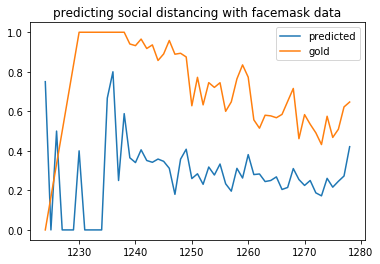

In [215]:
plot_data_predicted = convert(data_predicted)
plot_data_gold = convert(data_gold)

plt.plot([x[0] for x in plot_data_predicted], [x[1] for x in plot_data_predicted], label="predicted")
plt.plot([x[0] for x in plot_data_gold], [x[1] for x in plot_data_gold], label="gold")
plt.legend()
plt.title("predicting social distancing with facemask data")
plt.show()

## Predicting facemasks with social distancing data

In [216]:
predictionCountsValidation,predictionLabelsValidation,predictionCountsTest,predictionLabelsTest = \
    runFasttext(fasttext_data_list_distance, fasttext_data_list_facemask, squealFlag=False, dim=300)

0 cases: 132; precision: 0.508; recall: 0.508; fraction: 0.258
1 cases: 132; precision: 0.439; recall: 0.439; fraction: 0.213
2 cases: 133; precision: 0.406; recall: 0.406; fraction: 0.142
3 cases: 132; precision: 0.515; recall: 0.515; fraction: 0.110
4 cases: 132; precision: 0.356; recall: 0.356; fraction: 0.238
5 cases: 132; precision: 0.394; recall: 0.394; fraction: 0.140
6 cases: 132; precision: 0.356; recall: 0.356; fraction: 0.275
7 cases: 133; precision: 0.398; recall: 0.398; fraction: 0.225
8 cases: 132; precision: 0.371; recall: 0.371; fraction: 0.195
9 cases: 132; precision: 0.424; recall: 0.424; fraction: 0.391
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  209               144                205
__label__REJECTS                      97               204                248
__label__SUPPORTS                     38                3

In [230]:
predicted = []
for i in range(0, len(predictionLabelsTest)):
    for j in range(0, len(predictionLabelsTest[i][0])):
        predicted.append(predictionLabelsTest[i][0][j])

data_predicted = {}
for i in range(0, len(tweet_ids_facemask)):
    summary = str(tweet_ids_facemask[i])[0:1]
    if summary not in data_predicted:
        data_predicted[summary] = []
    data_predicted[summary].append(predicted[i][0])

In [231]:
gold = []
for tweet in fasttext_data_list_facemask:
    gold.append(tweet.split()[0])

data_gold = {}
for i in range(0, len(tweet_ids_facemask)):
    summary = str(tweet_ids_facemask[i])[0:1]
    if summary not in data_gold:
        data_gold[summary] = []
    data_gold[summary].append(gold[i])

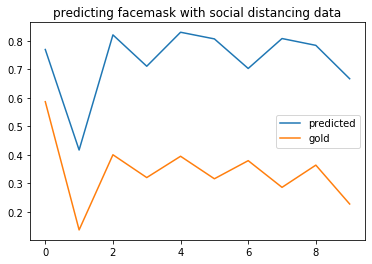

In [232]:
plot_data_predicted = convert(data_predicted)
plot_data_gold = convert(data_gold)

plt.plot([x[0] for x in plot_data_predicted], [x[1] for x in plot_data_predicted], label="predicted")
plt.plot([x[0] for x in plot_data_gold], [x[1] for x in plot_data_gold], label="gold")
plt.legend()
plt.title("predicting facemask with social distancing data")
plt.show()